<a href="https://colab.research.google.com/github/lilakhd/Network-and-Graph-Theory-Analysis-of-fMRI-data/blob/main/Computational_Neuroscience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COMPUTATIONAL NEUROSCIENCE**

**Date of Submission:** 06.08.2021 


# I. PART (I) - FUNCTIONAL CONNECTIVITY & GRAPH THEORY MEASUREMENTS

## 1. Importing Libraries & Dependencies for PART I 



In [ ]:
# Basic libraries
import numpy as np                
import matplotlib.pyplot as plt   
import seaborn as sb              
from scipy import stats           
import zipfile as zf    
import pandas as pd          
from google.colab import output  

# Installing additional libraries *not* included in Google Colab
!pip install bctpy                # brain connectivity toolbox to get graph theoretical models
!pip install nilearn              # brain network plotting
!pip install pyreadr              # reading R.data files

# Importing additional libraries
import bct as bct                 
from nilearn import plotting    
import pyreadr                    

# Clearing output
output.clear()

## 2. Importing the Dataset From Practical (3)

The dataset represents resting state fMRI data from a group of healthy participants.
The variables in the dataset are:
- Functional connectivity,
- Age, 
- Sex,
- Scanner site, *and*
- Framewise displacement (avg head motion (in mm)).

### 2.1 Storing the data

In [ ]:
# Creating a folder to store the data
!mkdir FC

# Subsetting to keep only participants who do not move head in scanner
!wget -O FC/nspn.fmri.lowmot.RData https://ndownloader.figshare.com/files/20958702

# Downloading region coordinates
!wget -O FC/fc_coords_mmp_mni.txt https://www.dropbox.com/s/rj73jjlpdrsrkvw

# Clearing output
output.clear()

### 2.2 Importing the data

In [ ]:
# Storing data directory
fc_data_dir = 'FC'

# Loading functional connectivity data from RData file
fc_r = pyreadr.read_r(fc_data_dir+'/nspn.fmri.lowmot.RData')

# Extracting key dataset variables 
## 1. Functional Connectivity
fc = np.asarray(fc_r['fc.lowmot']) 
## 2. Age                       
age_f = np.asarray(fc_r['age.lowmot'],dtype=float)[:,0]
## 3. Sex
sex_f = np.asarray(fc_r['sex.lowmot'],dtype=str)[:,0]
## 4. Scanner Site (3 possible sites)
site_f = np.asarray(fc_r['site.lowmot'],dtype=str)[:,0]
## 5. Framewise Displacement (= Average head motion (in mm))   
fd_f = np.asarray(fc_r['fd.lowmot'],dtype=float)[:,0]
## 6. Participant ID     
subj_f = np.asarray(fc_r['id.lowmot'],dtype=int)[:,0]     

# Regional coordinates
fc_coords = np.genfromtxt(fc_data_dir+'/fc_coords_mmp_mni.txt',delimiter=' ')

## 3. Combining data into a pandas dataframe

In [ ]:
# Combining demographic data, site data, and framewise displaceent data into a pandas dataframe
df = pd.DataFrame({'age': age_f, 'sex': sex_f, 'site': site_f, 'fd': fd_f, 'subj': subj_f})

# Number of duplicate scans
dup_min = df.subj.value_counts().min()
dup_max = df.subj.value_counts().max()  
print(f"Initially each participant has between {dup_min} and {dup_max} scans included in the dataset")

# Dropping duplicate scans (i.e. multiple scans from same participant to keep only the first scan)
df = df.drop_duplicates(subset=['subj'], keep='first')
df = df.reset_index(drop=True) # resetting dataframe index
print("Duplicate scans were dropped and only the first scan for each participant was retained")

# Drop duplicates from FC array (based on index) 
fc = fc[:,:,df.index]

Initially each participant has between 1 and 3 scans included in the dataset
Duplicate scans were dropped and only the first scan for each participant was retained


## 4. Inspecting the dataset

In [ ]:
# Visual inspection of first few rows
df.head()
# Descriptives
print(df.describe(include='all')) 
## Age: M= 19.51, SD = 2.68, Min= 14.65, Max = 25.78
## Framewise Displacement: M = 0.072, SD = 0.02, Min = 0.032, Max = 0.13
print("-------------------")
print(df['sex'].value_counts()) # Sex Distribution by Count
print(df['sex'].value_counts(normalize=True)) # Sex Distribution by Proportion
print("-------------------")
print(df['site'].value_counts()) # Site Distribution by Count
print(df['site'].value_counts(normalize=True)) # Site Distribution by Proportion


               age     sex  site          fd          subj
count   132.000000     132   132  132.000000    132.000000
unique         NaN       2     3         NaN           NaN
top            NaN  female  wbic         NaN           NaN
freq           NaN      71    99         NaN           NaN
mean     19.509621     NaN   NaN    0.071610  23009.712121
std       2.682228     NaN   NaN    0.020012   9339.240955
min      14.650000     NaN   NaN    0.031675  10702.000000
25%      17.322500     NaN   NaN    0.056617  13405.750000
50%      19.260000     NaN   NaN    0.072767  22194.000000
75%      21.537500     NaN   NaN    0.084922  29494.500000
max      25.780000     NaN   NaN    0.133742  42689.000000
-------------------
female    71
male      61
Name: sex, dtype: int64
female    0.537879
male      0.462121
Name: sex, dtype: float64
-------------------
wbic    99
ucl     23
cbsu    10
Name: site, dtype: int64
wbic    0.750000
ucl     0.174242
cbsu    0.075758
Name: site, dtype: float64


All variables have a count of 132. There are no missing values in any of the variables.

In [ ]:
ns_f = df.shape[0]                # number of subjects
nr_f = fc.shape[0]                # number of regions
triu_f = np.triu_indices(nr_f,1)  # indices of upper triangular elements of matrix

print(f"A total of {ns_f} participants were included in the final dataset")
print(f"A total of {nr_f} regions were included in the final analysis")

A total of 132 participants were included in the final dataset
A total of 346 regions were included in the final analysis


## 5. Recoding string variables to integer 

This step is a requirement to be able to feed the data to XGBoost algorithm,

In [ ]:
# Defining a function to recode sex variable from string to integer
def sex_to_numeric(x):
        if x=='female': return 1
        if x=='male':   return 0

# Generating a new sex variable that is recoded
df['sex_rec'] = df['sex'].apply(sex_to_numeric)

# Defining a function to recode site variable from string to integer
def site_to_numeric(x):
        if x=='wbic': return 2
        if x=='ucl' : return 1
        if x=='cbsu': return 0
# Generating a new site variable that is recoded
df['site_rec'] = df['site'].apply(site_to_numeric)

# II. Part (II): Functional Connectivity & Graph Theory Measures

In [ ]:
# Creating a variable to store thresholded data
fc_thr = np.zeros(fc.shape)

# Edge density (10 chosen arbitrarily)
dens_thr = 10

# Perform thresholding
for s in range(ns_f):                                                   # loop over subjects
    fc_thr[:,:,s] = bct.threshold_proportional(fc[:,:,s],dens_thr/100)  # proportional threshold for each subject


In [ ]:
# Initialising a variable to store mean FC
fc_mn = np.zeros(ns_f)

# Averaging each FC matrix (using the upper triangular part)
for s in range(ns_f):
    fc_mn[s] = np.mean(fc[:,:,s][triu_f])

# Adding this variable (averaged FC marix) to the existing dataframe with subject-level data
df = df.assign(fc_mn = fc_mn)

In [ ]:
# Calculating graph theory metrics

# Initialising empty variables in the existing dataframe
df['eff'] = np.nan
df['clust'] = np.nan

# Looping over subjects to calculate graph measures (binary global efficiency & average clustering across nodes)
for s in range(ns_f):
    if s % 30 == 0: print(f"Subject {s} of {ns_f}.")                    # tracking progress of looping
    # Graph measures
    df.loc[s,'eff'] = bct.efficiency_bin(fc_thr[:,:,s])                 # binary global efficiency
    df.loc[s,'clust'] = np.mean(bct.clustering_coef_bu(fc_thr[:,:,s]))  # average clustering across nodes

Subject 0 of 132.
Subject 30 of 132.
Subject 60 of 132.
Subject 90 of 132.
Subject 120 of 132.


# III. Part (III): Prediction Modelling - XGBoost


Developing an XGBOOST model to predict sex from the following input variables:


*   Mean functional connectivity over 346 regions
*   2 Graph theory metrics (binary global efficiency & average clustering across nodes)
*   Age (continuous variable)
*   Site (categorical variable)





## 1. Installing Libraries and Dependencies for Part III.

In [ ]:
from sklearn.model_selection import cross_val_score,  train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import loadtxt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
# Defining Random State (for reproducibility)
random_state=333

## 2. Defining input and output variables + splitting dataset

In [ ]:
# Input variables to be used in XGBOOST
X = df[['eff','age','clust','fc_mn','fd']]
# Outcome variable to be predicted using XGBOOST
Y = df['sex_rec']
# Splitting dataset into training (80%) and testing (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = random_state)

## 3. Defining hyperparameter search grids

In [ ]:
from collections import Counter
# estimating the scale_pos_weight value to include in grid search.
counter = Counter(Y)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 0.859


In [ ]:
# Defining hyperparameter search grids

## Positive Scaling (for class imbalance)
xgb_scale_pos_weight = [int(x) for x in np.linspace(0.9,5,10)]

## Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

## Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

## Minimum number of instances needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

## Learning Rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

## Learning objective used
xgb_objective = ['reg:logistic']

## Evaluation metric used 
xgb_eval_metric = ['aucpr'] 

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'scale_pos_weight': xgb_scale_pos_weight, 
            'eta': xgb_eta,
            'objective': xgb_objective,
            'eval_metric': xgb_eval_metric}


## 4. Model selection and evaluation

In [ ]:
# Base model to be tuned
xgb_base = XGBClassifier()

# Cross-validated Randomised Search Model
xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 10, verbose = 2, 
                                random_state = random_state, n_jobs = -1)

# Fitting the random search model to training data
xgb_random.fit(X_train, Y_train.astype(int))

# Best parameters from cross-validated randomised search model
print("Best parameters: ")
xgb_random.best_params_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1262 tasks      | elapsed:  1.4min


Best parameters: 


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.2min finished


{'eta': 0.4,
 'eval_metric': 'aucpr',
 'max_depth': 12,
 'min_child_weight': 8,
 'n_estimators': 200,
 'objective': 'reg:logistic',
 'scale_pos_weight': 1}

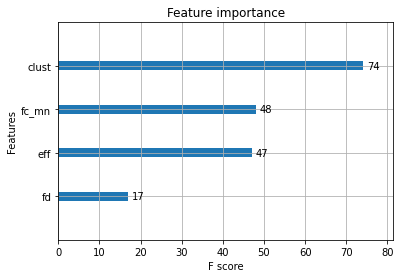

              precision    recall  f1-score   support

           0       0.56      0.42      0.48        12
           1       0.61      0.73      0.67        15

    accuracy                           0.59        27
   macro avg       0.58      0.57      0.57        27
weighted avg       0.59      0.59      0.58        27



In [ ]:
# Final model created using best parameters (fit to all training set)
best_model = xgb_random.best_estimator_

# Feature importance
plot_importance(best_model, max_num_features=4)
plt.show()

# Predicting probabilities in unseen hold out test set based on final (best) model
y_preds = best_model.predict(X_test)
# Model evaluation on test set
print(classification_report(y_test, y_preds))


In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc